In [1]:
%load_ext autoreload
%autoreload 2

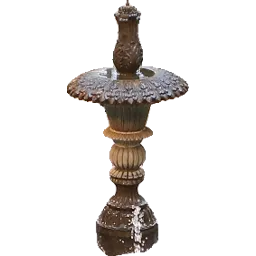

In [141]:
from PIL import Image
from PIL.Image import Image as ImageType
import numpy as np
from itertools import islice
import tqdm.auto

from segmentation.loading import DATA_DIR, images_in_dir


x = list(islice(images_in_dir(DATA_DIR / "cutouts2"), 50))
reference_image = Image.open(x[10])


def set_alpha_to_1(image: ImageType):
    # set alpha from 255 to 1 and keep the 0 alpha at 0
    image = image.convert("RGBA")
    data = np.array(image)
    data[..., 3] = np.where(data[..., 3] > 0, 1, 0)
    image = Image.fromarray(data)
    return image


reference_image

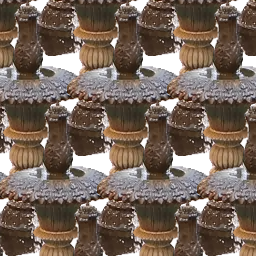

In [170]:
from segmentation.placement import place_image
from pydantic import BaseModel

# canvas = np.zeros((reference_image.height, reference_image.width), dtype=np.uint8)
# as PIL:
canvas = Image.new("RGBA", (256, 256), 0)


class TilingConfig(BaseModel):
    delta1: tuple[int, int]
    delta2: tuple[int, int]


def place_tiled(canvas: ImageType, reference_image: ImageType, config: TilingConfig):
    dx1, dy1 = config.delta1
    dx2, dy2 = config.delta2

    for i in range(-20, 20):
        for j in range(-20, 20):
            # skip if the image would be completely out of bounds
            x, y = (i * dx1 + j * dx2, i * dy1 + j * dy2)
            if x + reference_image.width < 0 or y + reference_image.height < 0:
                continue
            if x > canvas.width or y > canvas.height:
                continue

            canvas = place_image(
                canvas,
                reference_image,
                (x, y),
                allow_out_of_bounds=True,
            )

    return canvas


# canvas = place_image(canvas, reference_image, (0, 0))
place_tiled(canvas, reference_image, TilingConfig(delta1=(100, 0), delta2=(30, 100)))

In [171]:
def score_tiling(
    canvas: ImageType,
    reference_image: ImageType,
    config: TilingConfig,
) -> list[float]:
    reference_image_1 = set_alpha_to_1(reference_image)
    canvas = place_tiled(canvas, reference_image_1, config)
    alpha = np.array(canvas)[..., 3]

    # The fraction of empty space is an affine combination of frac_exact
    # and frac_overlap. Linear combinations of these two will therefore also
    # implicitly penalize/encourage empty space.
    frac_exact = np.mean(alpha == 1)
    frac_overlap = np.mean(alpha > 1)

    return frac_exact - frac_overlap

In [172]:
config = TilingConfig(delta1=(30, 10), delta2=(0, 10))
score_tiling(canvas, reference_image, config)

-1.0

In [199]:
def iter_deltas():
    for dx in range(0, 256, 32):
        for dy in range(0, 256, 32):
            yield (dx, dy)


def iter_configs():
    for delta1 in iter_deltas():
        for delta2 in iter_deltas():
            # check that delta2 is "on the right" of delta1
            if delta1[0] * delta2[1] - delta1[1] * delta2[0] < 0:
                yield TilingConfig(delta1=delta1, delta2=delta2)

In [200]:
from segmentation.optimization import select_best

best_score = 0
best_config = None

best_config, best_score = select_best(
    tqdm.auto.tqdm(iter_configs()), lambda x: score_tiling(canvas, reference_image, x)
)

0it [00:00, ?it/s]

In [175]:
best_score

0.6649932861328125

In [176]:
best_config

TilingConfig(delta1=(32, 192), delta2=(96, 128))

In [146]:
best_config

TilingConfig(delta1=(32, 192), delta2=(96, 128))

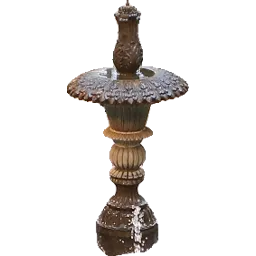

In [177]:
reference_image

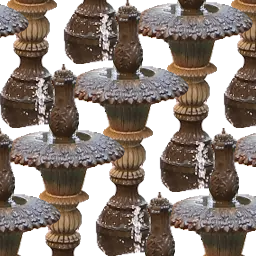

In [178]:
place_tiled(canvas, reference_image, best_config)

In [35]:
# convert to numpy
data = np.array(x)

In [40]:
# count occurrences of differnet values in alpha
np.unique(data[:, :, 3], return_counts=True)
# data[:,:,3]

(array([0, 1, 2, 3], dtype=uint8), array([179262, 487530, 374542,   7242]))

In [183]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
# pbounds = {"x1": (0, 256), "y1": (0, 256), "x2": (0, 256), "y2": (0, 256)}
# base_solution = delta1=(32, 192), delta2=(96, 128)
base_solution = {"x1": 32, "y1": 192, "x2": 96, "y2": 128}
pbounds = {k: (v - 32, v + 32) for k, v in base_solution.items()}


def f(x1, y1, x2, y2):
    return score_tiling(
        canvas,
        reference_image,
        TilingConfig(delta1=(int(x1), int(y1)), delta2=(int(x2), int(y2))),
    )


optimizer = BayesianOptimization(
    f=f,
    pbounds=pbounds,
    random_state=1,
)

In [184]:
optimizer.maximize(
    init_points=50,
    n_iter=200,
)

|   iter    |  target   |    x1     |    x2     |    y1     |    y2     |
-------------------------------------------------------------------------
| 1         | 0.4398    | 26.69     | 110.1     | 160.0     | 115.3     |
| 2         | 0.2944    | 9.392     | 69.91     | 171.9     | 118.1     |
| 3         | 0.6006    | 25.39     | 98.48     | 186.8     | 139.9     |
| 4         | 0.1789    | 13.08     | 120.2     | 161.8     | 138.9     |
| 5         | 0.5298    | 26.71     | 99.76     | 169.0     | 108.7     |
| 6         | 0.609     | 51.25     | 126.0     | 180.1     | 140.3     |
| 7         | 0.5866    | 56.09     | 121.3     | 165.4     | 98.5      |
| 8         | 0.1955    | 10.87     | 120.2     | 166.3     | 123.0     |
| 9         | 0.4897    | 61.3      | 98.12     | 204.3     | 116.2     |
| 10        | 0.3952    | 43.94     | 117.4     | 161.2     | 144.0     |
| 11        | 0.3571    | 63.29     | 111.9     | 177.9     | 146.5     |
| 12        | 0.5001    | 6.606     | 

In [185]:
optimizer.max

{'target': 0.7337799072265625,
 'params': {'x1': 44.11404479628518,
  'x2': 102.47007322256512,
  'y1': 186.5775202920123,
  'y2': 96.0}}

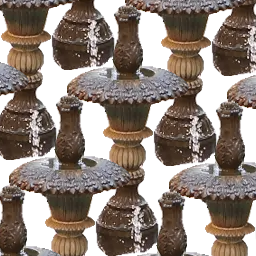

In [186]:
place_tiled(
    canvas,
    reference_image,
    TilingConfig(
        delta1=(
            int(optimizer.max["params"]["x1"]),
            int(optimizer.max["params"]["y1"]),
        ),
        delta2=(
            int(optimizer.max["params"]["x2"]),
            int(optimizer.max["params"]["y2"]),
        ),
    ),
)

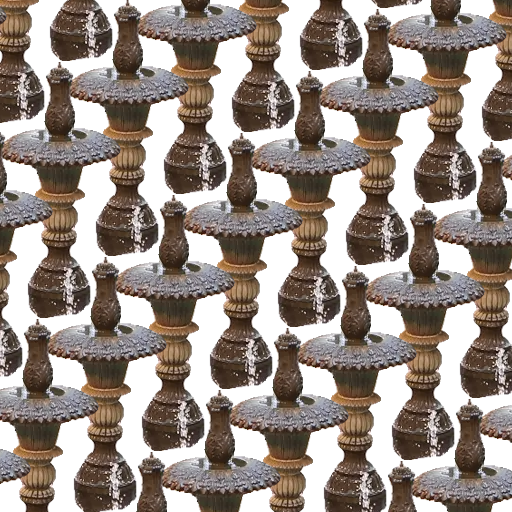

In [168]:
place_tiled(
    canvas,
    reference_image,
    TilingConfig(
        delta1=(
            int(optimizer.max["params"]["x1"]),
            int(optimizer.max["params"]["y1"]),
        ),
        delta2=(
            int(optimizer.max["params"]["x2"]),
            int(optimizer.max["params"]["y2"]),
        ),
    ),
)

In [214]:
import diskcache

In [215]:
cache = diskcache.Cache(directory=DATA_DIR / "escher" / "cache")

/Users/vaclav/prog/segmentation/data/cutouts2/sa_000020/00223750_00030.webp
/Users/vaclav/prog/segmentation/data/cutouts2/sa_000020/00223759_00080.webp


0it [00:00, ?it/s]

0.8202362060546875
delta1=(192, 224) delta2=(224, 64)


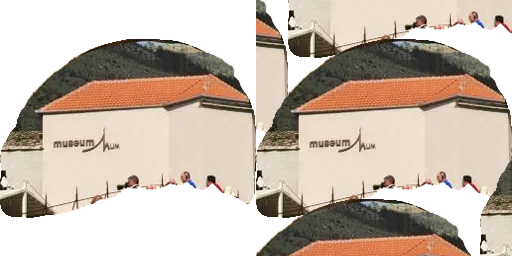

In [224]:
from segmentation.placement import to_mask
from segmentation.visualization import show_comparison


def is_reasonable(image):
    # image = image.crop(image.getbbox())
    # if image.width < 100 or image.height < 100:
    #     return False

    if to_mask(image).mean() < 0.1:
        return False

    return True


for path in list(islice(images_in_dir(DATA_DIR / "cutouts2"), 0, 2000, 100)):
    reference_image = Image.open(path)

    print(path)
    if not is_reasonable(reference_image):
        continue

    best_config, best_score = select_best(
        tqdm.auto.tqdm(iter_configs()),
        lambda x: score_tiling(canvas, reference_image, x),
    )

    cache[f"v1:{path}"] = {
        "score": best_score,
        "config": best_config.model_dump(mode="json"),
        "path": path,
        "image": place_tiled(canvas, reference_image, best_config),
    }

    print(best_score)
    print(best_config)
    # display(place_tiled(canvas, reference_image, best_config))
    display(
        show_comparison(
            reference_image, place_tiled(canvas, reference_image, best_config)
        )
    )
    break

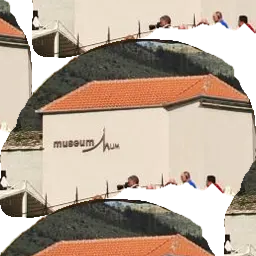

In [227]:
cache["v1:/Users/vaclav/prog/segmentation/data/cutouts2/sa_000020/00223759_00080.webp"][
    "image"
]

In [ ]:
/Users/vaclav/prog/segmentation/data/cutouts2/sa_000020/00223906_00066.webp

In [204]:
DATA_DIR

PosixPath('/Users/vaclav/prog/segmentation/data')

In [206]:
# list files in a .tar file
import tarfile

with tarfile.open(DATA_DIR / "sa_1b" / "compressed" / "sa_000020.tar") as tar:
    x = tar.getnames()

len(x)

22373

In [209]:
x[2]

'./sa_226692.jpg'

In [212]:
# open a specific file
with tarfile.open(DATA_DIR / "sa_1b" / "compressed" / "sa_000020.tar") as tar:
    pass
    x = tar.extractfile("./sa_223906.jpg")
    # x = tar.extractfile("sa_000020/00223906_00066.webp")
    x = Image.open(x)
    x.show()